# Fig. 6 - Retrieved 1D versus 3D GCM
This Jupyter notebooks reproduces Figure 6. The output .png and .pdf files are saved in <em>/figures</em>. Retrieved 1D P-T and chemical profiles on the 3D GCM HRS dataset show atmospheric conditions are broadly retrieved, although chemical abundances are slightly underestimated.

In [14]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import matplotlib.gridspec as gridspec
from matplotlib import colormaps
import os 

Load $\tau=2/3$ values at $\phi=0.59$.

In [15]:
phase = 213.75
_, _, tau_CO = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_CO', 'rb'))
_, _, tau_H2O = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_H2O', 'rb'))
_, _, tau_cont = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_continuum', 'rb'))
nlat, nlon_vis = tau_CO.shape
lon_vis_min = phase-90.
lon_vis_max = phase+90.
lon_vis = np.linspace(lon_vis_min, lon_vis_max, nlon_vis)
geometric_factor = np.cos((lon_vis-180.)/180.*np.pi)
n_equator = int(0.5*nlat)

Define some utitlity functions to plot the P-T and chemical profiles.

In [16]:
%matplotlib inline

cmap = colormaps['inferno']
c1 = 'k'
c2 = cmap(0.9)

def plot_retrieved_pt_chemistry(fig, axes, pressure, longs, profiles, tau_CO, tau_H2O, tau_cont, phase, plot_max=False, plot_min=False):
    ax, ax2, ax3 = axes

    nlongs = len(longs)
    init = True
    for lon_i in range(nlongs):
        temperature = profiles[:, lon_i, 0]
        abundance_CO = profiles[:, lon_i, 1]
        abundance_H2O = profiles[:, lon_i, 2]

        if init:
            temperature_min = np.copy(temperature)
            temperature_max = np.copy(temperature)
            abundance_CO_min = np.copy(abundance_CO)
            abundance_CO_max = np.copy(abundance_CO)
            abundance_H2O_min = np.copy(abundance_H2O)
            abundance_H2O_max = np.copy(abundance_H2O)
            init = False
        
        update_values = temperature < temperature_min
        temperature_min[update_values] = temperature[update_values]

        update_values = temperature > temperature_max
        temperature_max[update_values] = temperature[update_values]

        update_values = abundance_CO < abundance_CO_min
        abundance_CO_min[update_values] = abundance_CO[update_values]

        update_values = abundance_CO > abundance_CO_max
        abundance_CO_max[update_values] = abundance_CO[update_values]

        update_values = abundance_H2O < abundance_H2O_min
        abundance_H2O_min[update_values] = abundance_H2O[update_values]

        update_values = abundance_H2O > abundance_H2O_max
        abundance_H2O_max[update_values] = abundance_H2O[update_values]
    
    ax3.fill_betweenx(x1=temperature_min, x2=temperature_max, y=pressure,
                      color='gray', alpha=0.5)
    ax.fill_betweenx(x1=abundance_CO_min, x2=abundance_CO_max, y=pressure,
                      color='gray', alpha=0.5)
    ax2.fill_betweenx(x1=abundance_H2O_min, x2=abundance_H2O_max, y=pressure,
                      color='gray', alpha=0.5)

    return fig, (ax,ax2,ax3), pressure, temperature, temperature_min, temperature_max, abundance_H2O_min, abundance_H2O_max, abundance_CO_min, abundance_CO_max

def compute_H2O_dissociation_profile(P, T, logH2O):
    """Compute water chemical profile as function of pressure
    based on the results from Parmetier et al. 2018."""
    a = 10**logH2O
    b = 10**(2.0 * np.log10(P) + 4.83 * 1e4/T - 15.9)
    c = 1./np.sqrt(a) + 1./np.sqrt(b)
    return (1./c)**2

Plot figure.

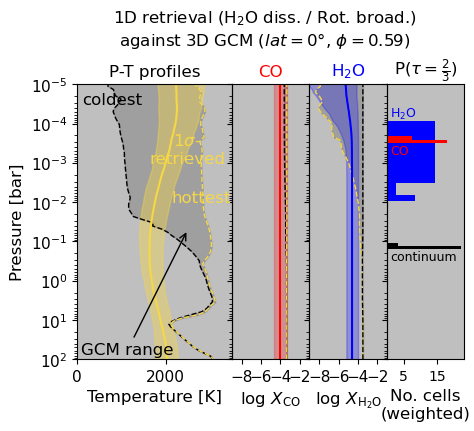

In [19]:
dirin = '../data/gcm/'
dirin_retrieval = '../data/pmn_out_3D/'
dirout = '../figures/'
lats = [0.]
phases = [212.40]
fnames = []
for phase, lat in zip(phases, lats):
    fname = f'gcm_pt_and_chemistry_{phase:.2f}_{lat:.2f}.pic'
    fnames.append(fname)

fig = plt.figure(figsize=(5,6/1.68))
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[1,0.5,0.5,0.5],wspace=0)
ax = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[0,0])
ax4 = fig.add_subplot(gs[0,3])

for fname, phase in zip(fnames, phases):
    pressure, longs, profiles, tau_CO, tau_H2O, tau_cont = pickle.load(open(dirin+fname, 'rb'))
    p_out = plot_retrieved_pt_chemistry(fig, (ax, ax2, ax3), pressure, longs, profiles, tau_CO, tau_H2O, tau_cont, phase)
    fig, (ax,ax2,ax3), pressure, temperature, temperature_min, temperature_max, abundance_H2O_min, abundance_H2O_max, abundance_CO_min, abundance_CO_max = p_out
    ax3.plot(temperature_min, pressure, color=c1, lw=1, ls='--')
    ax3.plot(temperature_max, pressure, color=c2, lw=1, ls='--')
    ax2.plot(abundance_H2O_min, pressure, color=c2, lw=1, ls='--')
    ax2.plot(abundance_H2O_max, pressure, color=c1, lw=1, ls='--')
    ax.plot(abundance_CO_min, pressure, color=c1, lw=1, ls='--')
    ax.plot(abundance_CO_max, pressure, color=c2, lw=1, ls='--')
    
ax.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

ax.set_ylim(10**2,10**-5)
ax2.set_ylim(10**2,10**-5)
ax3.set_ylim(10**2,10**-5)

ax.set_xlim(-9,-1)
ax2.set_xlim(-9,-1)
ax3.set_xlim(0,3500)

ax2.set_yticklabels([])
ax.set_yticklabels([])

ax.set_title('CO', color='red', fontsize=12)
ax2.set_title('H$_2$O', color='blue', fontsize=12)
ax3.set_title('P-T profiles', color='k', fontsize=12)

ax.set_xticks([-2,-4,-6,-8])
ax2.set_xticks([-2,-4,-6,-8])


#ax.set_clip_on(False)
#ax.set_annotation_clip(False)


ax.patch.set_facecolor('black')
ax.patch.set_alpha(0.25)
ax2.patch.set_facecolor('black')
ax2.patch.set_alpha(0.25)
ax3.patch.set_facecolor('black')
ax3.patch.set_alpha(0.25)
ax4.patch.set_facecolor('black')
ax4.patch.set_alpha(0.25)

# Added panel for tau=2/3
phase = 213.75
_, _, tau_CO = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_CO', 'rb'))
_, _, tau_H2O = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_H2O', 'rb'))
_, _, tau_cont = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_continuum', 'rb'))
nlat, nlon_vis = tau_CO.shape
lon_vis_min = phase-90.
lon_vis_max = phase+90.
lon_vis = np.linspace(lon_vis_min, lon_vis_max, nlon_vis)
geometric_factor = np.cos((lon_vis-180.)/180.*np.pi)
n_equator = int(0.5*nlat)
ax4.hist(tau_H2O[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='blue')
ax4.hist(tau_CO[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='red')
ax4.hist(tau_cont[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='black')

ax4.set_title(r'P($\tau=\frac{2}{3})$', size=12)
ax4.set_yscale('log')
ax4.set_ylim(1e2,1e-5)
ax4.set_xlim(0,)
ax4.set_xticks([5,15])
ax4.set_xticklabels([5,15])
ax4.set_yticklabels([])
ax4.set_xlabel('No. cells\n(weighted)', size=12)


P_retrieved, _, Tlow_1sig, Tmed, Thigh_1sig, _ = pickle.load(open(dirin_retrieval+'/pt_profile.pic', 'rb'))
ax3.plot(Tmed, P_retrieved, color=c2)
ax3.fill_betweenx(y=P_retrieved, x1=Tlow_1sig, x2=Thigh_1sig, color=c2, alpha=0.4)

P_retrieved, _, logH2Olow_1sig, logH2Omed, logH2Ohigh_1sig, _ = pickle.load(open(dirin_retrieval+'/H2O_profile.pic', 'rb'))
ax2.fill_betweenx(y=P_retrieved, x1=np.log10(logH2Olow_1sig), x2=np.log10(logH2Ohigh_1sig), color='blue', alpha=0.25)
ax2.plot(np.log10(logH2Omed), P_retrieved, color='blue')

abund_constraints = pickle.load(open(dirin_retrieval+'/CO_stats.pic', 'rb'))
ablvls = (abund_constraints[0]+abund_constraints[1], abund_constraints[0], abund_constraints[0]+abund_constraints[2])
ax.fill_betweenx(y=pressure, x1=ablvls[0], x2=ablvls[2], color='red', alpha=0.25)
ax.axvline(ablvls[1], color='red')

ax3.annotate(r'GCM range', xytext=(100,7.5e1), xy=(2500,5e-2),  arrowprops=dict(facecolor='black', arrowstyle="->"), color='k', fontsize=12)
ax3.annotate('1$\sigma$-\nretrieved', xy=(2500,1e-3), color=c2, fontsize=12, ha='center')
ax3.annotate('coldest', xy=(800,10**-4.5), color=c1, fontsize=12, ha='center')
ax3.annotate('hottest', xy=(2800,1e-2), color=c2, fontsize=12, ha='center')

ax.set_xlabel(r'log $X_{\rm{CO}}$', size=12)
ax2.set_xlabel(r'log $X_{\rm{H_2O}}$', size=12)
ax3.set_xlabel('Temperature [K]', size=12)
ax3.set_ylabel('Pressure [bar]', size=12)

ax.xaxis.set_tick_params(labelsize=11)
ax2.xaxis.set_tick_params(labelsize=11)
ax3.xaxis.set_tick_params(labelsize=11)
ax3.yaxis.set_tick_params(labelsize=11)

ax4.annotate('continuum', xy=(1, 0.3), fontsize=9)
ax4.annotate(r'H$_2$O', xy=(1, 0.7e-4), fontsize=9, color='blue')
ax4.annotate('CO', xy=(1, 6e-4), fontsize=9, color='red')


plt.suptitle(r'1D retrieval (H$_2$O diss. / Rot. broad.)' + '\n' + r'against 3D GCM ($lat=0\degree$, $\phi=0.59$)' + '\n' + r'', y =1.09, size=12)

plt.savefig(dirout+'/Fig6_Panel1_retrieved_1D_versus_3D_GCM.pdf', bbox_inches='tight')
plt.savefig(dirout+'/Fig6_Panel1_retrieved_1D_versus_3D_GCM.png', dpi=250, bbox_inches='tight')
plt.show()

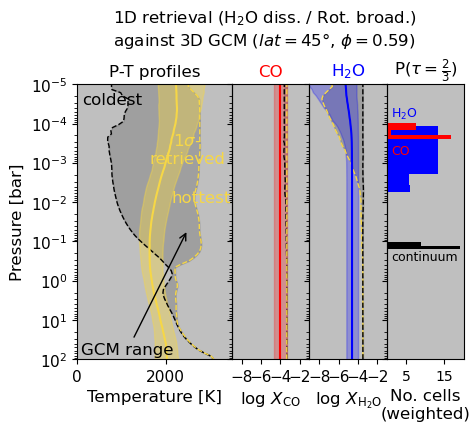

In [20]:
%matplotlib inline
dirin = '../data/gcm/'
dirin_retrieval = '../data/pmn_out_3D/'
dirout = '../figures/'
lats = [45.]
phases = [212.40]
fnames = []
for phase, lat in zip(phases, lats):
    fname = f'gcm_pt_and_chemistry_{phase:.2f}_{lat:.2f}.pic'
    fnames.append(fname)

fig = plt.figure(figsize=(5,6/1.68))
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[1,0.5,0.5,0.5],wspace=0)
ax = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[0,0])
ax4 = fig.add_subplot(gs[0,3])

for fname, phase in zip(fnames, phases):
    pressure, longs, profiles, tau_CO, tau_H2O, tau_cont = pickle.load(open(dirin+fname, 'rb'))
    p_out = plot_retrieved_pt_chemistry(fig, (ax, ax2, ax3), pressure, longs, profiles, tau_CO, tau_H2O, tau_cont, phase)
    fig, (ax,ax2,ax3), pressure, temperature, temperature_min, temperature_max, abundance_H2O_min, abundance_H2O_max, abundance_CO_min, abundance_CO_max = p_out
    ax3.plot(temperature_min, pressure, color=c1, lw=1, ls='--')
    ax3.plot(temperature_max, pressure, color=c2, lw=1, ls='--')
    ax2.plot(abundance_H2O_min, pressure, color=c2, lw=1, ls='--')
    ax2.plot(abundance_H2O_max, pressure, color=c1, lw=1, ls='--')
    ax.plot(abundance_CO_min, pressure, color=c1, lw=1, ls='--')
    ax.plot(abundance_CO_max, pressure, color=c2, lw=1, ls='--')

ax.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

ax.set_ylim(10**2,10**-5)
ax2.set_ylim(10**2,10**-5)
ax3.set_ylim(10**2,10**-5)

ax.set_xlim(-9,-1)
ax2.set_xlim(-9,-1)
ax3.set_xlim(0,3500)

ax2.set_yticklabels([])
ax.set_yticklabels([])

ax.set_title('CO', color='red', fontsize=12)
ax2.set_title('H$_2$O', color='blue', fontsize=12)
ax3.set_title('P-T profiles', color='k', fontsize=12)

ax.set_xticks([-2,-4,-6,-8])
ax2.set_xticks([-2,-4,-6,-8])

ax.patch.set_facecolor('black')
ax.patch.set_alpha(0.25)
ax2.patch.set_facecolor('black')
ax2.patch.set_alpha(0.25)
ax3.patch.set_facecolor('black')
ax3.patch.set_alpha(0.25)
ax4.patch.set_facecolor('black')
ax4.patch.set_alpha(0.25)

# Added panel for revision
phase = 213.75
_, _, tau_CO = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_CO', 'rb'))
_, _, tau_H2O = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_H2O', 'rb'))
_, _, tau_cont = pickle.load(open(f'../data/gcm/tau_2_3_map_{phase}_continuum', 'rb'))
nlat, nlon_vis = tau_CO.shape
lon_vis_min = phase-90.
lon_vis_max = phase+90.
lon_vis = np.linspace(lon_vis_min, lon_vis_max, nlon_vis)
geometric_factor = np.cos((lon_vis-180.)/180.*np.pi)
n_equator = int(0.75*nlat)
ax4.hist(tau_H2O[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='blue')
ax4.hist(tau_CO[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='red')
ax4.hist(tau_cont[n_equator, :]/1e5, bins=3, weights=geometric_factor, orientation='horizontal', color='black')

ax4.set_title(r'P($\tau=\frac{2}{3})$', size=12)
ax4.set_yscale('log')
ax4.set_ylim(1e2,1e-5)
ax4.set_xlim(0,)
ax4.set_xticks([5,15])
ax4.set_xticklabels([5,15])
ax4.set_yticklabels([])
ax4.set_xlabel('No. cells\n(weighted)', size=12)


P_retrieved, _, Tlow_1sig, Tmed, Thigh_1sig, _ = pickle.load(open(dirin_retrieval+'/pt_profile.pic', 'rb'))
ax3.plot(Tmed, P_retrieved, color=c2)
ax3.fill_betweenx(y=P_retrieved, x1=Tlow_1sig, x2=Thigh_1sig, color=c2, alpha=0.4)

P_retrieved, _, logH2Olow_1sig, logH2Omed, logH2Ohigh_1sig, _ = pickle.load(open(dirin_retrieval+'/H2O_profile.pic', 'rb'))
ax2.fill_betweenx(y=P_retrieved, x1=np.log10(logH2Olow_1sig), x2=np.log10(logH2Ohigh_1sig), color='blue', alpha=0.25)
ax2.plot(np.log10(logH2Omed), P_retrieved, color='blue')

abund_constraints = pickle.load(open(dirin_retrieval+'/CO_stats.pic', 'rb'))
ablvls = (abund_constraints[0]+abund_constraints[1], abund_constraints[0], abund_constraints[0]+abund_constraints[2])
ax.fill_betweenx(y=pressure, x1=ablvls[0], x2=ablvls[2], color='red', alpha=0.25)
ax.axvline(ablvls[1], color='red')

ax3.annotate(r'GCM range', xytext=(100,7.5e1), xy=(2500,5e-2),  arrowprops=dict(facecolor='black', arrowstyle="->"), color='k', fontsize=12)
ax3.annotate('1$\sigma$-\nretrieved', xy=(2500,1e-3), color=c2, fontsize=12, ha='center')
ax3.annotate('coldest', xy=(800,10**-4.5), color=c1, fontsize=12, ha='center')
ax3.annotate('hottest', xy=(2800,1e-2), color=c2, fontsize=12, ha='center')

ax.set_xlabel(r'log $X_{\rm{CO}}$', size=12)
ax2.set_xlabel(r'log $X_{\rm{H_2O}}$', size=12)
ax3.set_xlabel('Temperature [K]', size=12)
ax3.set_ylabel('Pressure [bar]', size=12)

ax.xaxis.set_tick_params(labelsize=11)
ax2.xaxis.set_tick_params(labelsize=11)
ax3.xaxis.set_tick_params(labelsize=11)
ax3.yaxis.set_tick_params(labelsize=11)

ax4.annotate('continuum', xy=(1, 0.3), fontsize=9)
ax4.annotate(r'H$_2$O', xy=(1, 0.7e-4), fontsize=9, color='blue')
ax4.annotate('CO', xy=(1, 6e-4), fontsize=9, color='red')


plt.suptitle(r'1D retrieval (H$_2$O diss. / Rot. broad.)' + '\n' + r'against 3D GCM ($lat=45\degree$, $\phi=0.59$)' + '\n' + r'', y =1.09, size=12)

plt.savefig(dirout+'/Fig6_Panel2_retrieved_1D_versus_3D_GCM.pdf', bbox_inches='tight')
plt.savefig(dirout+'/Fig6_Panel2_retrieved_1D_versus_3D_GCM.png', dpi=250, bbox_inches='tight')
plt.show()